In [21]:
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import numpy as np

In [22]:
def load_and_preprocess_image(image_path):
    """Load and preprocess an image."""
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = (img - 0.5) * 2  # Normalize between [-1, 1]
    img = tf.image.resize(img, [256, 256])
    return img

In [23]:
def deprocess_image(img):
    """De-process the image to bring back to [0, 255] range."""
    img = (img * 0.5 + 0.5) * 255
    img = img.numpy().astype(np.uint8)
    return img

In [24]:
def generate_and_display(image_path, monet_generator, photo_generator, is_monet_to_photo=False):
    """
    Generate Monet-style image from a normal photo using the generator or vice versa.

    Args:
    - image_path (str): Path to the input image (normal photo or Monet-style image)
    - monet_generator (Model): Generator that converts normal images to Monet-style
    - photo_generator (Model): Generator that converts Monet-style images to normal photos
    - is_monet_to_photo (bool): Set True if converting from Monet to photo, False otherwise.
    """

    # Load and preprocess the image
    img = load_and_preprocess_image(image_path)
    img = tf.expand_dims(img, axis=0)  # Add batch dimension

    # Convert the TensorFlow tensor to a PyTorch tensor
    img = torch.from_numpy(img.numpy()).permute(0, 3, 1, 2) # Adjust the dimensions to match PyTorch's format (B, C, H, W)


    if is_monet_to_photo:
        generated_image = photo_generator(img) # Remove training=False
        label = 'Monet-Style to Photo'
    else:
        generated_image = monet_generator(img) # Remove training=False
        label = 'Photo to Monet-Style'

    # Convert the PyTorch tensor back to a TensorFlow tensor
    generated_image = generated_image.permute(0, 2, 3, 1).detach().numpy() # Adjust the dimensions back to TensorFlow's format (B, H, W, C)
    generated_image = tf.convert_to_tensor(generated_image)

    # Deprocess the images for displaying
    original_image = deprocess_image(tf.squeeze(img.permute(0, 2, 3, 1))) # Transpose the image back to (H, W, C) before deprocessing
    generated_image = deprocess_image(tf.squeeze(generated_image))

    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')

    # Generated Image
    plt.subplot(1, 2, 2)
    plt.imshow(generated_image)
    plt.title(f"Generated: {label}")
    plt.axis('off')

    plt.show()

In [25]:
import torch
import torch.nn as nn

# Define the file paths to the saved models
monet_generator_path = '/content/monet_generator.pth'
photo_generator_path = '/content/photo_generator.pth'
monet_discriminator_path = '/content/monet_discriminator.pth'
photo_discriminator_path = '/content/photo_discriminator.pth'

# Assuming you have the same model architecture defined somewhere in your code, e.g., CycleGAN's Generator and Discriminator classes
class Generator(torch.nn.Module):
    # Define the architecture here
    def __init__(self):
        super(Generator, self).__init__()
        # Define the architecture of your GAN generator here
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=1, padding=3),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 3, 7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

class Discriminator(torch.nn.Module):
    # Define the architecture here
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(256, 1, 4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.main(x)

# Initialize the models (same architecture as the saved ones)
monet_generator = Generator()
photo_generator = Generator()
monet_discriminator = Discriminator()
photo_discriminator = Discriminator()

# Load the saved model weights
monet_generator.load_state_dict(torch.load(monet_generator_path, map_location=torch.device('cpu'))) # Load the model onto the CPU
photo_generator.load_state_dict(torch.load(photo_generator_path, map_location=torch.device('cpu'))) # Load the model onto the CPU
monet_discriminator.load_state_dict(torch.load(monet_discriminator_path, map_location=torch.device('cpu'))) # Load the model onto the CPU
photo_discriminator.load_state_dict(torch.load(photo_discriminator_path, map_location=torch.device('cpu'))) # Load the model onto the CPU

# Set the models to evaluation mode (for inference)
monet_generator.eval()
photo_generator.eval()
monet_discriminator.eval()
photo_discriminator.eval()

print("Models loaded successfully!")

Models loaded successfully!


<ipython-input-25-d558de2b7024>:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  monet_generator.load_state_dict(torch.load(monet_generator_path, map_location=torch.device(

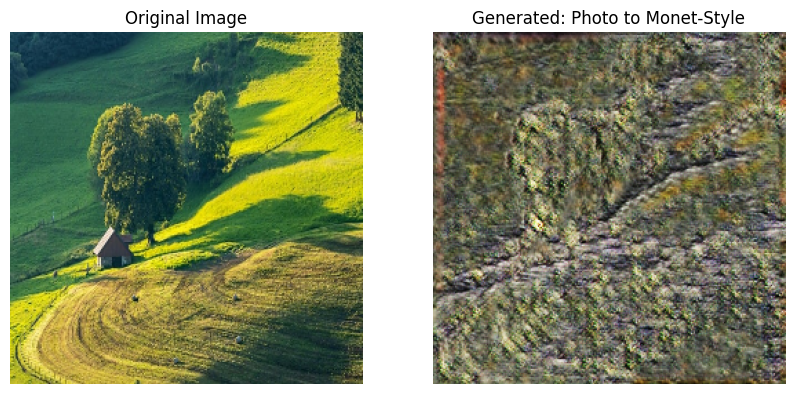

In [32]:
# Path to your input image
image_path_N = '/content/landscape-8592826_640.jpg'

# Convert a photo to Monet-style and display
generate_and_display(image_path_N, monet_generator, photo_generator, is_monet_to_photo=False)

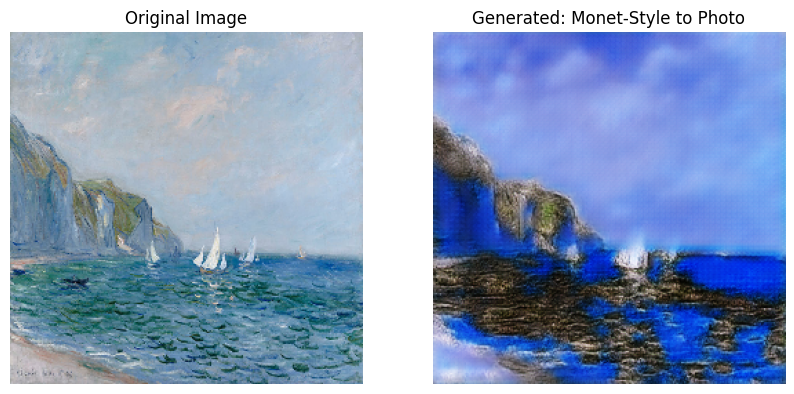

In [33]:
# Path to your input image
image_path_M = '/content/monet (2).jpg'

# Convert a Monet-style image back to a normal photo and display
generate_and_display(image_path_M, monet_generator, photo_generator, is_monet_to_photo=True)